# Bitcoin & Twitter

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from datetime import datetime
from pyspark.sql import *
from pyspark.sql.functions import col
from pyspark.sql import functions as F


sc = SparkContext("local")
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

21/10/19 13:28:16 WARN Utils: Your hostname, pop-os resolves to a loopback address: 127.0.1.1; using 192.168.1.6 instead (on interface wlp59s0)
21/10/19 13:28:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/10/19 13:28:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
#BITCOIN

# Unix Timestamp - Date represented as epoc value
# Date - date and time when the data point was collected
# Symbol - Symbol of the currency
# Open - Open value of the currency
# High - Highest value of currency in the given minute
# Low - Lowest value of currency in the given minute
# Close - Close value of the currency in the given minute
# Volume - Volume of the currency transacted in the given minute.

# TWITTER

# user_name	The name of the user, as they’ve defined it.
# user_location	The user-defined location for this account’s profile.
# user_description	The user-defined UTF-8 string describing their account.
# user_created	Time and date, when the account was created.
# user_followers	The number of followers an account currently has.
# user_friends	The number of friends a account currently has.
# user_favourites	The number of favorites a account currently has
# user_verified	When true, indicates that the user has a verified account
# date	UTC time and date when the Tweet was created
# text	The actual UTF-8 text of the Tweet
# hashtags	All the other hashtags posted in the tweet along with #Bitcoin & #btc
# source	Utility used to post the Tweet, Tweets from the Twitter website have a source value - web
# is_retweet	Indicates whether this Tweet has been Retweeted by the authenticating user.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
from scipy import stats as stat

In [4]:
btc_value_df = pd.read_csv('./data/bitcoinvalue.csv')
tweets_df = pd.read_csv('./data/tweets.csv')

tweets_schema = StructType([
StructField('user_name', StringType(), True),
StructField('user_location', StringType(), True),
StructField('user_description', StringType(), True),
StructField('user_created', StringType(), True),
StructField('user_followers', IntegerType(), True),
StructField('user_friends', IntegerType(), True),
StructField('user_favourites', StringType(), True),
StructField('user_verified', BooleanType(), True),
StructField('date', StringType(), True),
StructField('text', StringType(), True),
StructField('hashtags', StringType(), True),
StructField('source', StringType(), True),
StructField('is_retweet', BooleanType(), True),
])

# tweets_df = spark.read.csv(
#     "./data/tweets.csv", 
#     header=True, 
#     schema=tweets_schema)

btc_schema = StructType([
StructField('Unix Timestamp', StringType(), True),
StructField('Date', StringType(), True),
StructField('Symbol', StringType(), True),
StructField('Open', FloatType(), True),
StructField('High', FloatType(), True),
StructField('Low', FloatType(), True),
StructField('Close', FloatType(), True),
StructField('Volume', FloatType(), True),
])

btc_df = spark.read.csv(
    "./data/bitcoinvalue.csv", 
    header=True, 
    schema=btc_schema)

# tweets_df.show()
# btc_df.show()

/home/snenene/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (5,6,7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
#Function BEFORE

tweets_df["hashtags"]=tweets_df["hashtags"].apply(lambda s : s[1:-1].split(',') if isinstance(s,str) else [])
tweets_df["hashtags_len"]=tweets_df["hashtags"].apply(len)

#Function AFTER

# tweets_df = tweets_df.select(F.split(col('hashtags'), ",").alias("hastags_array")).drop('hashtags')

# Functions you have to convert to spark

def conv_to_int(val):
    if isinstance(val, str):
        return 0
    else:
        return float(val)
tweets_df["user_followers"]=tweets_df["user_followers"].apply(lambda x : conv_to_int(x))
tweets_df["user_friends"]=tweets_df["user_friends"].apply(lambda x : conv_to_int(x))
tweets_df["user_favourites"]=tweets_df["user_favourites"].apply(lambda x : conv_to_int(x))

def clean_text(text):
    if(isinstance(text, str)):
        text = text.replace("#","")
        text = re.sub('\\n', '', text)
        text = re.sub('https:\/\/\S+', '', text)
        return text
    else:
        return ""

tweets_df["clean_text"]=tweets_df["text"].apply(clean_text)
tweets_df.drop("text", axis=1, inplace=True)

tweets_df["date"]=pd.to_datetime(tweets_df["date"],errors='coerce')
tweets_df["date"]=tweets_df["date"].apply(lambda x: x.date() )

def generate_impact_score(tweet):
    coef_verified = 1.1 if tweet.user_verified else 1
    coef_hashtags = 1+(tweet.hashtags_len/20)
    return ((tweet.user_followers + (tweet.user_friends/4))*coef_verified*coef_hashtags)/100

tweets_df["impact_score"]=tweets_df.apply(generate_impact_score, axis=1)

btc_value_df['Date'] = pd.to_datetime(btc_value_df['Date'])

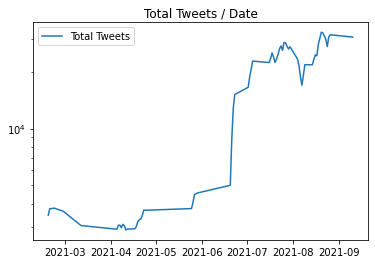

In [6]:
tweets_vol = tweets_df.groupby('date').size().rolling(10).mean().dropna()
fig, ax = plt.subplots()

ax.plot(tweets_vol.index,tweets_vol,label='Total Tweets')
ax.set_yscale('log')
ax.tick_params(axis='y')

lines, labels = ax.get_legend_handles_labels()

ax.legend(lines, labels, loc=0)
plt.title("Total Tweets / Date")

plt.show()

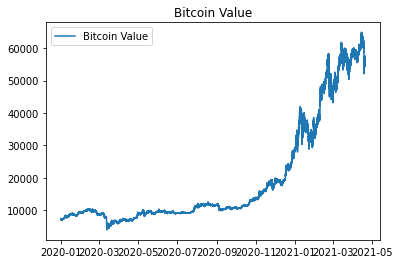

In [7]:
fig, ax = plt.subplots()
ax.plot(btc_value_df['Date'],btc_value_df['Open'],label='Bitcoin Value')
ax.tick_params(axis='y')

lines, labels = ax.get_legend_handles_labels()

ax.legend(lines, labels)
plt.title("Bitcoin Value")

plt.show()

In [8]:
tweets_schema = StructType([
StructField('user_name', StringType(), True),
StructField('user_location', StringType(), True),
StructField('user_description', StringType(), True),
StructField('user_created', StringType(), True),
StructField('user_followers', IntegerType(), True),
StructField('user_friends', IntegerType(), True),
StructField('user_favourites', StringType(), True),
StructField('user_verified', BooleanType(), True),
StructField('date', StringType(), True),
StructField('text', StringType(), True),
StructField('hashtags', StringType(), True),
StructField('source', StringType(), True),
StructField('is_retweet', BooleanType(), True),
])

tweets_df = spark.read.csv(
    "./data/tweets.csv", 
    header=True, 
    schema=tweets_schema)

btc_schema = StructType([
StructField('Unix Timestamp', StringType(), True),
StructField('Date', StringType(), True),
StructField('Symbol', StringType(), True),
StructField('Open', FloatType(), True),
StructField('High', FloatType(), True),
StructField('Low', FloatType(), True),
StructField('Close', FloatType(), True),
StructField('Volume', FloatType(), True),
])

btc_df = spark.read.csv(
    "./data/bitcoinvalue.csv", 
    header=True, 
    schema=btc_schema)
    
df_location = twitter_data.groupBy('user_location').count().sort(col("count").desc()).show()

NameError: name 'twitter_data' is not defined